In [1]:
import os
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
import scipy
from scipy import stats
from scipy import sparse
from scipy.stats import spearmanr, pearsonr
from scipy.spatial import distance_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import commot as ct
from statsmodels.stats import multitest
import copy
import math
import warnings
warnings.filterwarnings("ignore")

In [3]:
'load splane data'
data_quality = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/visium_matrix/visium_data_quality.csv',index_col=0)
spatial_domain = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/visium_matrix/spatial_domain_table.csv',index_col=0)
spatial_domain['sample'] = data_quality.loc[spatial_domain.index]['sample']

ER_dict = {8:'NM',9:'NM',  6:'ER1',2:'ER1',  3:'ER2',  5:'ER3',4:'ER3',  7:'ER4',0:'ER4',1:'ER4'}         
spatial_domain['Ecoregion'] = spatial_domain['spatial_domain'].map(ER_dict).tolist()

In [4]:
slide_self = ['P77_A1','P77_B1','P130_C1','P130_D1','P131_A1','P131_B1','P136_C1','P136_D1','P137_A1','P137_B1']
slide_publicy = ['T_243','T_248','T_251','T_255','T_259','T_260','T_262','T_266','T_269','T_275','T_296','T_334','Visium_S1']
slide_add = ['Pt1','Pt4','Pt5','Pt9','Pt10','Pt13','Pt14','GBM_2','GBM_3']
slice_id = slide_self + slide_publicy + slide_add

'Remove samples with too uneven spatial domain proportions, remove Pt1 and Pt13'
slice_id = slice_id[:23] + slice_id[24:28] + slice_id[29:]

In [5]:
def fdr_t_test(df, leiden_result, target, fdr_threshold=0.05):
    
    merge_df = copy.deepcopy(df)
    merge_df['leiden'] = leiden_result
    
    target_df = merge_df[merge_df['leiden']==target].drop('leiden',axis=1)
    rest_df = merge_df[merge_df['leiden']!=target].drop('leiden',axis=1)
    
    mean_target = target_df.mean().to_numpy()
    mean_rest = rest_df.mean().to_numpy()
    
    std_target = target_df.std().to_numpy()
    std_rest = rest_df.std().to_numpy()
    
    num_t, num_r = len(target_df), len(rest_df)
    
    modified_std_t = np.sqrt(num_t/(num_t-1)) * std_target
    modified_std_r = np.sqrt(num_r/(num_r-1)) * std_rest
    
    # t-test
    (statistic, pvalue) = stats.ttest_ind_from_stats(mean1=mean_target, 
                                                     std1=modified_std_t, 
                                                     nobs1=num_t, 
                                                     mean2=mean_rest, 
                                                     std2=modified_std_r, 
                                                     nobs2=num_r)
    
    pvalue = [1 if math.isnan(x) else x for x in pvalue]
    
    # fdr correction
    rejected, p_val_corrected = multitest.fdrcorrection(pvalue, 
                                                        alpha=fdr_threshold, 
                                                        method='indep', 
                                                        is_sorted=False)
    
    result_df = pd.DataFrame(index=df.columns, columns=['mean_in_target', 
                                                        'mean_in_rest',
                                                        'std_err_in_target',
                                                        'std_err_in_rest',
                                                        'p_val',
                                                        'p_val_corrected',
                                                        'rejected',
                                                        'target'])
    tar_list = [target]*len(target_df.columns)
    
    result_df['mean_in_target'] = mean_target
    result_df['mean_in_rest'] = mean_rest
    result_df['std_err_in_target'] = modified_std_t
    result_df['std_err_in_rest'] = modified_std_r
    result_df['p_val'] = pvalue
    result_df['p_val_corrected'] = p_val_corrected
    result_df['rejected'] = rejected
    result_df['target'] = tar_list
    
    return result_df

## Target:
1. Remove Non-Malignant
2. Remove ER with spot count < 50

## Load cellchat dataset

In [6]:
df_cellchat = ct.pp.ligand_receptor_database(species='human', signaling_type= None, database='CellChat')
our_interaction_db = pd.read_csv('/home/qukun/ccp1997/GBM_10X/In_depth/scRNA_matrix/interaction_input_CellChatDB.combined.v1.csv',sep = ',',index_col=0)
our_interaction_db_transfer = our_interaction_db[['ligand','receptor','pathway_name','annotation']]
our_interaction_db_transfer.columns = ['0','1','2','3']
our_interaction_db_transfer.index = range(our_interaction_db_transfer.shape[0])

In [7]:
done_index = len(slice_id)
read_result = []
def sub_read(idx):
    file_name = '/home/qukun/ccp1997/GBM_10X/ng_revised/commot/no_log_h5ad/' + slice_id[idx] + '_commot.h5ad'
    return sc.read_h5ad(file_name), idx

from multiprocessing.pool import Pool
with Pool(30) as pool:
    read_result = pool.map(sub_read, range(done_index))
    pool.close()
    pool.join()  
commot_adata = [read_result[i][0] for i in range(done_index)]

## Remove NM

In [9]:
commot_adata_v2 = []
for adata in commot_adata:
    adata.obs['Ecoregion'] = adata.obs['spatial_domain'].map(ER_dict).tolist()
    adata = adata[adata.obs['Ecoregion'] != 'NM']
    commot_adata_v2.append(adata)
    
commot_adata = commot_adata_v2

## Domain small than 50

In [11]:
commot_adata_v3 = []
for adata in commot_adata:
    select_cells = []
    for item in ['ER1','ER2','ER3','ER4']:
        if np.sum(adata.obs['Ecoregion'] == item) >= 50:
            select_cells = select_cells + adata.obs.loc[adata.obs['Ecoregion'] == item].index.tolist()
    commot_adata_v3.append(adata[select_cells])

commot_adata = commot_adata_v3

for k,adata in enumerate(commot_adata):
    adata.obs.index = [ item.split('-')[0]+'-'+slice_id[k]  for item in adata.obs.index ]

In [12]:
'fillna'
merge_adata = sc.concat(commot_adata,join='outer')

merge_adata.obsm['commot-our_db-sum-sender'] = merge_adata.obsm['commot-our_db-sum-sender'].fillna(0)
merge_adata.obsm['commot-our_db-sum-receiver'] = merge_adata.obsm['commot-our_db-sum-receiver'].fillna(0)

In [13]:
def get_LR_df(adata):
    r_spot = adata.obsm['commot-our_db-sum-receiver'].to_numpy()
    s_spot = adata.obsm['commot-our_db-sum-sender'].to_numpy()

    col = [p[2:] for p in adata.obsm['commot-our_db-sum-sender'].columns.tolist()]
    data = r_spot + s_spot
    spot_LR_df = pd.DataFrame(columns=col, index=adata.obsm['commot-our_db-sum-sender'].index, data=data)
    return spot_LR_df


def get_interaction_df(adata):
    interact_matrix = []
    pathway_name = [p[2:] for p in adata.obsm['commot-our_db-sum-sender'].columns.tolist()]
    for pathway in pathway_name:
        col_data = adata.obsp['commot-our_db-'+pathway].todense().sum(axis=0).tolist()[0]
        interact_matrix.append(col_data)
    interact_matrix = np.array(interact_matrix)
    interact_df = pd.DataFrame(data=interact_matrix, index=pathway_name, columns=adata.obsm['commot-our_db-sum-sender'].index.tolist())
    interact_df = interact_df.T
    return interact_df

In [15]:
'interaction db, contain complex'
interaction_db = pd.read_csv('/home/qukun/ccp1997/GBM_10X/In_depth/scRNA_matrix/interaction_input_CellChatDB.combined.v1.csv',index_col=0)

'stme interaction'
gbm = sc.read_h5ad('/home/qukun/ccp1997/GBM_10X/ng_revised/harmony/gbm_integrated_final_neurons.h5ad')
gbm.raw = gbm
sc.pp.normalize_total(gbm, target_sum=1e4)
sc.pp.log1p(gbm)

## t-test

In [18]:
USE_INTERACTION_MATRIX = False

LR_df = get_LR_df(merge_adata)
leiden_result = merge_adata.obs['Ecoregion'].tolist()

ER1_result = fdr_t_test(LR_df, 
                        leiden_result, 
                        target='ER1')


In [19]:
ligand_record = []
receptor_record = []
    
for lr_pair in ER1_result.index:
    if lr_pair.split('-') == [3]:
        ligand_record.append( lr_pair.split('-')[0] + '-' + lr_pair.split('-')[1] )
        receptor_record.append( lr_pair.split('-')[2] )
    else:
        ligand_record.append( lr_pair.split('-')[0] )
        receptor_record.append( lr_pair.split('-')[1] )
        
ER1_result['ligand'] = ligand_record
ER1_result['receptor'] = receptor_record
ER1_result['interaction'] = [  ER1_result.loc[item]['ligand'] + '_' + ER1_result.loc[item]['receptor']  for item in ER1_result.index]

'remove not exp and complex'
select = []
for item in ER1_result.index:
    if ( len(ER1_result.loc[item]['interaction'].split('_')) == 2 ) and ( len(np.intersect1d(ER1_result.loc[item]['interaction'].split('_'), gbm.var['features'])) == 2 ):
        select.append(item)
    else:
        continue

In [20]:
ER1_result = fdr_t_test(LR_df, 
                        leiden_result, 
                        target='ER1')


In [21]:
ER2_result = fdr_t_test(LR_df, 
                        leiden_result, 
                        target='ER2')


In [22]:
ER3_result = fdr_t_test(LR_df, 
                        leiden_result, 
                        target='ER3')


In [23]:
ER4_result = fdr_t_test(LR_df, 
                        leiden_result, 
                        target='ER4')


In [24]:
'filter complex and not expression'
ER1_result = ER1_result.loc[select]
ER2_result = ER2_result.loc[select]
ER3_result = ER3_result.loc[select]
ER4_result = ER4_result.loc[select]

In [25]:
'change name'
ER1_result.index = [ item.split('-')[0] + '_' + item.split('-')[1] for item in ER1_result.index]
ER2_result.index = [ item.split('-')[0] + '_' + item.split('-')[1] for item in ER2_result.index]
ER3_result.index = [ item.split('-')[0] + '_' + item.split('-')[1] for item in ER3_result.index]
ER4_result.index = [ item.split('-')[0] + '_' + item.split('-')[1] for item in ER4_result.index]

In [26]:
'load LR frequency'
stme1_dataframe = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/commot/cutoff50/stme1_dataframe.csv',index_col=0)
stme2_dataframe = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/commot/cutoff50/stme2_dataframe.csv',index_col=0)
stme3_dataframe = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/commot/cutoff50/stme3_dataframe.csv',index_col=0)
stme4_dataframe = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/commot/cutoff50/stme4_dataframe.csv',index_col=0)

In [27]:
STME1_record = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/commot/STME1_reult_record.csv',index_col=0)
STME2_record = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/commot/STME2_reult_record.csv',index_col=0)
STME3_record = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/commot/STME3_reult_record.csv',index_col=0)
STME4_record = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/commot/STME4_reult_record.csv',index_col=0)

In [28]:
'save compare'
ER1_result_compare = ER1_result
ER2_result_compare = ER2_result
ER3_result_compare = ER3_result
ER4_result_compare = ER4_result

In [29]:
'generate compare'
counts = []
for inter in ER1_result_compare.index:
    if inter in stme1_dataframe.index:
        counts.append(stme1_dataframe.loc[inter]['counts'])
    else:
        counts.append(0)

ER1_result_compare['counts'] = counts

counts = []
for inter in ER2_result_compare.index:
    if inter in stme2_dataframe.index:
        counts.append(stme2_dataframe.loc[inter]['counts'])
    else:
        counts.append(0)

ER2_result_compare['counts'] = counts

counts = []
for inter in ER3_result_compare.index:
    if inter in stme3_dataframe.index:
        counts.append(stme3_dataframe.loc[inter]['counts'])
    else:
        counts.append(0)

ER3_result_compare['counts'] = counts

counts = []
for inter in ER4_result_compare.index:
    if inter in stme4_dataframe.index:
        counts.append(stme4_dataframe.loc[inter]['counts'])
    else:
        counts.append(0)

ER4_result_compare['counts'] = counts

In [30]:
'ER1 plot'

'ER1 plot'

In [31]:
minimum_value = ER2_result.loc[ER2_result['p_val_corrected'] != 0.0].sort_values('p_val_corrected')['p_val_corrected'][0]

ER1_result['FC'] = list(ER1_result['mean_in_target']/ER1_result['mean_in_rest'])
ER1_result = ER1_result.loc[ER1_result['FC'] >= 1]

ER1_result['logFDR'] = [ -1 * math.log10(item+minimum_value) for item in ER1_result['p_val_corrected']]
ER1_result['logFC'] = [ math.log2(item) for item in ER1_result['FC']]

counts = []
for inter in ER1_result.index:
    if inter in stme1_dataframe.index:
        counts.append(stme1_dataframe.loc[inter]['counts'])
    else:
        counts.append(0)

ER1_result['counts'] = counts

ER2_result['FC'] = list(ER2_result['mean_in_target']/ER2_result['mean_in_rest'])
ER2_result = ER2_result.loc[ER2_result['FC'] >= 1]

ER2_result['logFDR'] = [ -1 * math.log10(item+minimum_value) for item in ER2_result['p_val_corrected']]
ER2_result['logFC'] = [ math.log2(item) for item in ER2_result['FC']]

counts = []
for inter in ER2_result.index:
    if inter in stme2_dataframe.index:
        counts.append(stme2_dataframe.loc[inter]['counts'])
    else:
        counts.append(0)

ER2_result['counts'] = counts

ER3_result['FC'] = list(ER3_result['mean_in_target']/ER3_result['mean_in_rest'])
ER3_result = ER3_result.loc[ER3_result['FC'] >= 1]

ER3_result['logFDR'] = [ -1 * math.log10(item+minimum_value) for item in ER3_result['p_val_corrected']]
ER3_result['logFC'] = [ math.log2(item) for item in ER3_result['FC']]

counts = []
for inter in ER3_result.index:
    if inter in stme3_dataframe.index:
        counts.append(stme3_dataframe.loc[inter]['counts'])
    else:
        counts.append(0)

ER3_result['counts'] = counts

ER4_result['FC'] = list(ER4_result['mean_in_target']/ER4_result['mean_in_rest'])
ER4_result = ER4_result.loc[ER4_result['FC'] >= 1]

ER4_result['logFDR'] = [ -1 * math.log10(item+minimum_value) for item in ER4_result['p_val_corrected']]
ER4_result['logFC'] = [ math.log2(item) for item in ER4_result['FC']]

counts = []
for inter in ER4_result.index:
    if inter in stme4_dataframe.index:
        counts.append(stme4_dataframe.loc[inter]['counts'])
    else:
        counts.append(0)

ER4_result['counts'] = counts

In [36]:
merge_db = interaction_db.loc[interaction_db['pathway_name'] == 'VEGF'].index.tolist() + interaction_db.loc[interaction_db['pathway_name'] == 'IL6'].index.tolist() +\
interaction_db.loc[interaction_db['pathway_name'] == 'MIF'].index.tolist() + interaction_db.loc[interaction_db['pathway_name'] == 'COLLAGEN'].index.tolist() +\
interaction_db.loc[interaction_db['pathway_name'] == 'LAMININ'].index.tolist() + interaction_db.loc[interaction_db['pathway_name'] == 'TGFb'].index.tolist() +\
interaction_db.loc[interaction_db['pathway_name'] == 'THBS'].index.tolist() + interaction_db.loc[interaction_db['pathway_name'] == 'NOTCH'].index.tolist() +\
interaction_db.loc[interaction_db['pathway_name'] == 'FN1'].index.tolist() +\
interaction_db.loc[interaction_db['pathway_name'] == 'PDGF'].index.tolist() + interaction_db.loc[interaction_db['pathway_name'] == 'SEMA3'].index.tolist() +\
interaction_db.loc[interaction_db['pathway_name'] == 'ACTIVIN'].index.tolist() + interaction_db.loc[interaction_db['pathway_name'] == 'HSPG'].index.tolist() +\
interaction_db.loc[interaction_db['pathway_name'] == 'INSULIN'].index.tolist() + interaction_db.loc[interaction_db['pathway_name'] == 'ANGPT'].index.tolist() +\
interaction_db.loc[interaction_db['pathway_name'] == 'EDN'].index.tolist() + interaction_db.loc[interaction_db['pathway_name'] == 'NRXN'].index.tolist() +\
interaction_db.loc[interaction_db['pathway_name'] == 'EPHB'].index.tolist() + interaction_db.loc[interaction_db['pathway_name'] == 'SEMA6'].index.tolist() +\
interaction_db.loc[interaction_db['pathway_name'] == 'GDF'].index.tolist() + interaction_db.loc[interaction_db['pathway_name'] == 'PTN'].index.tolist()



In [39]:
'filter'
ER1_result_filter = ER1_result.loc[ER1_result['mean_in_target'] >= 0.01]

color_list = []
for inter in ER1_result_filter.index:
    if (ER1_result_filter.loc[inter]['FC'] >= 1.25)&(ER1_result_filter.loc[inter]['logFDR'] >= 20):
        color_list.append('#B42373')
    else:
        color_list.append('grey')

ER1_result_filter['color'] = color_list

'only select pathway'
ER1_result_filter = ER1_result_filter.loc[np.intersect1d(ER1_result_filter.index,merge_db)]

ER1_pass = []
for inter in ER1_result_filter.index:
    if ER1_result_filter.loc[inter]['color'] == 'grey':
        ER1_pass.append(inter)
    else:
        adj_FDR = []
        for k in [ER2_result_compare,ER3_result_compare,ER4_result_compare]:
            if k.loc[inter]['FC'] < 1:
                adj_FDR.append(1)
            else:
                adj_FDR.append(k.loc[inter]['p_val_corrected'])  
        
        if ((ER1_result_compare.loc[inter]['counts'] >= 4) & (ER1_result_compare.loc[inter]['p_val_corrected'] <= np.min(adj_FDR) )) & (ER1_result_compare.loc[inter]['mean_in_target'] >= 0.05):
            ER1_pass.append(inter)

ER1_result_filter = ER1_result_filter.loc[ER1_pass]


size = []
for inter in ER1_result_filter.index:
    size.append( (ER1_result_filter.loc[inter]['counts'] + 1)*4 )
ER1_result_filter['size'] = size

ER1_result_filter['pathway'] = interaction_db.loc[ER1_result_filter.index]['pathway_name']

(0.0, 320.0)

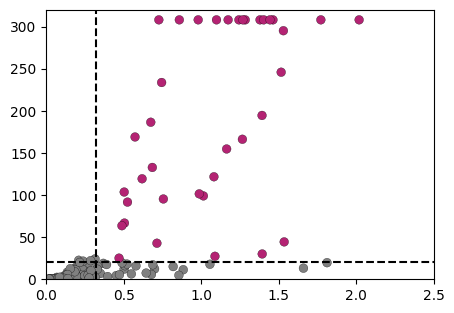

In [40]:
plt.figure(figsize=(5,3.5))
plt.scatter(x=ER1_result_filter['logFC'],y=ER1_result_filter['logFDR'],s= 40,c=ER1_result_filter['color'],linewidths=0.2,edgecolors='black')   
plt.hlines(y=20,xmin=0.0,xmax=2.5,linestyles='dashed',linewidths=1.5,colors='black')
plt.vlines(x=math.log2(1.25),ymin=0,ymax=320,linestyles='dashed',linewidths=1.5,colors='black')
plt.xlim(0,2.5)
plt.ylim(0,320)
#plt.savefig('/home/qukun/ccp1997/GBM_10X/ng_revised/figure/result_2/four_quadrant_ER1_commot.pdf')

In [44]:
ER1_result_filter.loc[ER1_result_filter['color'] != 'grey'].to_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/commot/ER1_four_quadrant.csv')   


In [48]:
'filter'
ER2_result_filter = ER2_result.loc[ER2_result['mean_in_target'] >= 0.01]

color_list = []
for inter in ER2_result_filter.index:
    if (ER2_result_filter.loc[inter]['FC'] >= 1.25)&(ER2_result_filter.loc[inter]['logFDR'] >= 20):
        color_list.append('#B43826')
    else:
        color_list.append('grey')

ER2_result_filter['color'] = color_list

'only select pathway'
ER2_result_filter = ER2_result_filter.loc[np.intersect1d(ER2_result_filter.index,merge_db)]

ER2_pass = []
for inter in ER2_result_filter.index:
    if ER2_result_filter.loc[inter]['color'] == 'grey':
        ER2_pass.append(inter)
    else:
        adj_FDR = []
        for k in [ER1_result_compare,ER3_result_compare,ER4_result_compare]:
            if k.loc[inter]['FC'] < 1:
                adj_FDR.append(1)
            else:
                adj_FDR.append(k.loc[inter]['p_val_corrected']) 
   
        if ((ER2_result_compare.loc[inter]['counts'] >= 4) & (ER2_result_compare.loc[inter]['p_val_corrected'] <= np.min(adj_FDR) )) & (ER2_result_compare.loc[inter]['mean_in_target'] >= 0.05):
            ER2_pass.append(inter)

ER2_result_filter = ER2_result_filter.loc[ER2_pass]

size = []
for inter in ER2_result_filter.index:
    size.append( (ER2_result_filter.loc[inter]['counts'] + 1)*4 )
ER2_result_filter['size'] = size

ER2_result_filter['pathway'] = interaction_db.loc[ER2_result_filter.index]['pathway_name']

(0.0, 320.0)

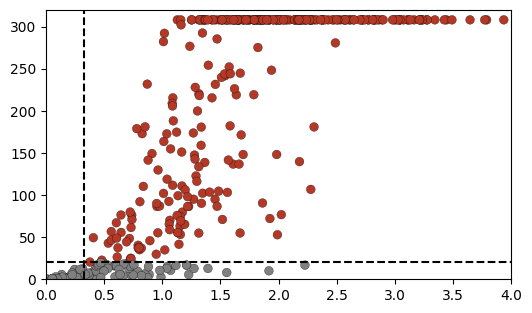

In [50]:
plt.figure(figsize=(6,3.5))
plt.scatter(x=ER2_result_filter['logFC'],y=ER2_result_filter['logFDR'],s= 40,c=ER2_result_filter['color'],linewidths=0.2,edgecolors='black')   
plt.hlines(y=20,xmin=0.0,xmax=4.0,linestyles='dashed',linewidths=1.5,colors='black')
plt.vlines(x=math.log2(1.25),ymin=0,ymax=320,linestyles='dashed',linewidths=1.5,colors='black')
plt.xlim(0,4.0)
plt.ylim(0,320)
#plt.savefig('/home/qukun/ccp1997/GBM_10X/ng_revised/figure/result_2/four_quadrant_ER2_commot.pdf')


In [62]:
ER2_result_filter.loc[ER2_result_filter['color'] != 'grey'].to_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/commot/ER2_four_quadrant.csv')     


In [92]:
'filter'
ER3_result_filter = ER3_result.loc[ER3_result['mean_in_target'] >= 0.01]

color_list = []
for inter in ER3_result_filter.index:
    if (ER3_result_filter.loc[inter]['FC'] >= 1.25)&(ER3_result_filter.loc[inter]['logFDR'] >= 20):
        color_list.append('#5FBE9B')
    else:
        color_list.append('grey')

ER3_result_filter['color'] = color_list

'only select pathway'
ER3_result_filter = ER3_result_filter.loc[np.intersect1d(ER3_result_filter.index,merge_db)]

ER3_pass = []
for inter in ER3_result_filter.index:
    if ER3_result_filter.loc[inter]['color'] == 'grey':
        ER3_pass.append(inter)
    else:
        adj_FDR = []
        for k in [ER1_result_compare,ER2_result_compare,ER4_result_compare]:
            if k.loc[inter]['FC'] < 1:
                adj_FDR.append(1)
            else:
                adj_FDR.append(k.loc[inter]['p_val_corrected']) 
                
        if ((ER3_result_compare.loc[inter]['counts'] >= 4) & (ER3_result_compare.loc[inter]['p_val_corrected'] <= np.min(adj_FDR) )) & (ER3_result_compare.loc[inter]['mean_in_target'] >= 0.05):   
            ER3_pass.append(inter)

ER3_result_filter = ER3_result_filter.loc[ER3_pass]


size = []
for inter in ER3_result_filter.index:
    size.append( (ER3_result_filter.loc[inter]['counts'] + 1)*4 )
ER3_result_filter['size'] = size

ER3_result_filter['pathway'] = interaction_db.loc[ER3_result_filter.index]['pathway_name']

(0.0, 320.0)

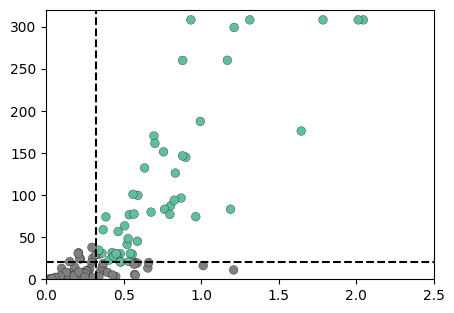

In [93]:
plt.figure(figsize=(5,3.5))
plt.scatter(x=ER3_result_filter['logFC'],y=ER3_result_filter['logFDR'],s= 40,c=ER3_result_filter['color'],linewidths=0.2,edgecolors='black')   
plt.hlines(y=20,xmin=0.0,xmax=2.5,linestyles='dashed',linewidths=1.5,colors='black')
plt.vlines(x=math.log2(1.25),ymin=0,ymax=320,linestyles='dashed',linewidths=1.5,colors='black')
plt.xlim(0,2.5)
plt.ylim(0,320)
#plt.savefig('/home/qukun/ccp1997/GBM_10X/ng_revised/figure/result_2/four_quadrant_ER3_commot.pdf')


In [97]:
ER3_result_filter.loc[ER3_result_filter['color'] != 'grey'].to_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/commot/ER3_four_quadrant.csv')  


In [158]:
'filter'
ER4_result_filter = ER4_result.loc[ER4_result['mean_in_target'] >= 0.01]

color_list = []
for inter in ER4_result_filter.index:
    if (ER4_result_filter.loc[inter]['FC'] >= 1.25)&(ER4_result_filter.loc[inter]['logFDR'] >= 20):
        color_list.append('#F4A947')
    else:
        color_list.append('grey')

ER4_result_filter['color'] = color_list

'only select pathway'
ER4_result_filter = ER4_result_filter.loc[np.intersect1d(ER4_result_filter.index,merge_db)]

ER4_pass = []
for inter in ER4_result_filter.index:
    if ER4_result_filter.loc[inter]['color'] == 'grey':
        ER4_pass.append(inter)
    else:
        adj_FDR = []
        for k in [ER1_result_compare,ER2_result_compare,ER3_result_compare]:
            if k.loc[inter]['FC'] < 1:
                adj_FDR.append(1)
            else:
                adj_FDR.append(k.loc[inter]['p_val_corrected']) 
                   
        if ((ER4_result_compare.loc[inter]['counts'] >= 6) & (ER4_result_compare.loc[inter]['p_val_corrected'] <= np.min(adj_FDR) )) & (ER4_result_compare.loc[inter]['mean_in_target'] >= 0.05):   
            ER4_pass.append(inter)

ER4_result_filter = ER4_result_filter.loc[ER4_pass]


size = []
for inter in ER4_result_filter.index:
    size.append( (ER4_result_filter.loc[inter]['counts'] + 1)*4 )
ER4_result_filter['size'] = size

ER4_result_filter['pathway'] = interaction_db.loc[ER4_result_filter.index]['pathway_name']

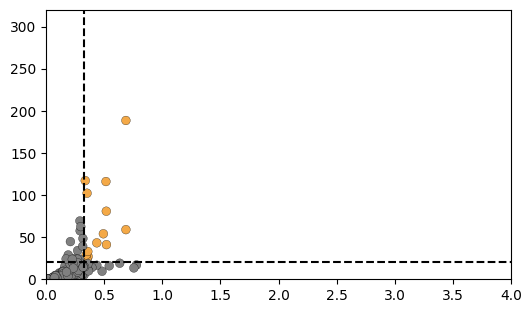

In [76]:
plt.figure(figsize=(6.0,3.5))
plt.scatter(x=ER4_result_filter['logFC'],y=ER4_result_filter['logFDR'],s= 40,c=ER4_result_filter['color'],linewidths=0.2,edgecolors='black')   
plt.hlines(y=20,xmin=0.0,xmax=4.0,linestyles='dashed',linewidths=1.5,colors='black')
plt.vlines(x=math.log2(1.25),ymin=0,ymax=320,linestyles='dashed',linewidths=1.5,colors='black')
plt.xlim(0,4.0)
plt.ylim(0,320)
#plt.savefig('/home/qukun/ccp1997/GBM_10X/ng_revised/figure/result_2/four_quadrant_ER4_commot.pdf')


In [80]:
ER4_result_filter.loc[ER4_result_filter['color'] != 'grey'].to_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/commot/ER4_four_quadrant.csv')    
